In [ ]:
'''
system import
'''
import math
from collections import deque
from datetime import datetime, timedelta
from os import close

'''
stock API import
'''
import tushare as ts


'''
data processing import
'''
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


'''
gymnasium import
'''
import gymnasium
from gymnasium import spaces


'''
pytorch import
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler


'''
ray import
'''
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.modelv2 import ModelV2
from ray.rllib.utils.annotations import override
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.misc import SlimFC
from ray.rllib.algorithms import ppo
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import EnvContext
from ray.tune.registry import register_env


'''
fix seed
'''
np.random.seed(135)
torch.manual_seed(135)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55

Setup Env

In [ ]:
class PortfolioOptimizationEnv(gymnasium.Env):
    '''
    Environment setting with OpenAI

    Assumptions:
    1. In this case, the team has loose the constrain of 24 hours holding period. Once a person buy in the stock, the person can sell it immediately
    2. We have simplified the buy order mechanism so that stocks can be bought at the closing price of the day in this environment.

    State: A stack of stock price data, stock index data, current stock volums, current cash amount
    Observation: Same with state but in a 365 trading days duration
    Action: A float list with a length of N (number of stocks chosen) which elements are within range (-1,1). When positive -> buy Ni * cash amount of stock i. When negtive -> sell Ni present of stocki's volume

    '''

    def __init__(self,env_config):
        super(PortfolioOptimizationEnv, self).__init__()
        try:
            self.history_length = env_config['history_length']
            self.start = env_config['start']                        #define start date
            self.end = env_config['end']                            #define end date
            self.market = env_config['market']                      #define market -> currently only China
            self.n_stock = env_config['n_stock']                    #define the number of stock chosen
            self.cash = env_config['cash']                          #define the initial cash we take into the market
            self.smoothing_factor = env_config['smoothing_factor']  #define smooth for the DSR reward function

            self.market_data = self.load_market_data(self.start, self.end, self.market)         #Initialize market data during the start to end -> execute once to shorten running time
            self.close_data = self.load_full_close_data(self.start, self.end, self.market)      #Initialize close data

            self.stock_tensor_length = self.market_data.shape[1] - 1                                    #See observation_space
            self.date_list = self.load_trading_days(self.start, self.end, self.market)                  #Filter trading days from the period
            self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_stock,), dtype=np.float32)     #define action space, please see 'Action' in the class comment for detail
            self.observation_space = spaces.Box(                                                        #define observation space as required by Rllib, the observation space have to be a flattened np list
                low=-np.inf, high=np.inf,                                                               #Thus the dimension is calcualted as shape
                shape=(self.history_length * (self.stock_tensor_length + self.n_stock + 1 + self.n_stock + 1),),
                dtype=np.float32
            )

            self.state_buffer = deque(maxlen=self.history_length)           #define state deque
            self.initial_cash = np.float32(self.cash)                       #define cash buffer
            self.stock_volume = np.zeros(self.n_stock, dtype=np.float32)    #define stock volume recorder

            self.A_t = np.float32(0.0)
            self.B_t = np.float32(0.0)
            self.Previous_A_t = np.float32(0.0)
            self.Previous_B_t = np.float32(0.0)                             #define reward parameters
            self.net_price = np.array([], dtype=np.float32)                 #define net price loader
            self.current_step = 0                                           #define step recorder

        except Exception as e:
            print("Error during initialization:", e)
            raise


    def step(self, action):
        '''
        Step function, step forward according to policy model's return
        '''

        self.current_step += 1
        next_date = self.date_list[self.current_step]
        action = self.normalize_action(action)
        reward = self.calculate_reward(action, next_date)

        next_state = self.get_state(self.current_step, action,  reward, next_date)
        stacked_state = np.array(self.state_buffer).flatten().astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)

        done = self.net_price[-1] <= 0
        turncated = self.current_step >= len(self.date_list) - 1
        info = {
                "net_price": self.net_price[-1],  # Pass the current net price
                "cash": self.cash,  # Example: Pass cash if needed
            }

        '''log monitoring -> comment back when needed
        if self.current_step % 100 == 0:
          print('-------------------------------------------------')
          print(f'The net price is: {self.net_price[-1]}')
          print(f'The current step is: {self.current_step}')
          print(f'The cash is :{self.cash}')
          print(f'The stock volume is :{self.stock_volume}')
          print(f'The actions are: {action}')
        '''


        return stacked_state, reward, done, turncated, info




    def reset(self, seed = None, options = None):
        '''
        Reset function, reset the environment when an episode is done
        '''
        if seed is not None:
          np.random.seed(seed)
          torch.manual_seed(seed)
        self.state_buffer = deque(maxlen=self.history_length)
        self.cash = self.initial_cash
        self.stock_volume = np.zeros_like(self.stock_volume)
        self.A_t = np.float32(0.0)
        self.B_t = np.float32(0.0)
        self.Previous_A_t = np.float32(0.0)
        self.Previous_B_t = np.float32(0.0)
        self.net_price = np.zeros(self.history_length, dtype=np.float32)
        self.current_step = self.history_length

        self.date_list = self.load_trading_days(self.start, self.end, self.market)
        first_365_days = self.date_list[:self.history_length]

        for idx, date in enumerate(first_365_days):
            dummy_action = np.zeros(self.action_space.shape, dtype=np.float32)
            dummy_reward = 0.0
            next_state = self.get_state(idx, dummy_action, dummy_reward, date)

        stacked_state = np.array(self.state_buffer).flatten()
        stacked_state = stacked_state.astype(np.float32)
        stacked_state = np.nan_to_num(stacked_state, nan=1e-8, posinf=999999, neginf=-999999)
        return stacked_state, {}




    def get_state(self, idx, action, reward, date):
        '''
        Obtain state and return to step function
        '''
        stock_data_current = self.market_data[self.market_data['trade_date'] == date].iloc[0].drop(['trade_date']).values
        reward_array = np.array([reward], dtype=np.float32)
        net_price_current = np.array([self.net_price[self.current_step-1]], dtype=np.float32)
        full_state = np.concatenate([stock_data_current, action, reward_array, self.stock_volume, net_price_current])
        date_encodings = self.calculate_date_encoding(idx, full_state.shape[0])
        full_state_with_encoding = full_state + date_encodings
        self.state_buffer.append(full_state_with_encoding)
        return full_state_with_encoding



    def load_trading_days(self, start, end, market):
        '''
        Filter trading days
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            trade_cal = pro.trade_cal(exchange = '',start_date = start, end_date = end)
            trade_cal = trade_cal[trade_cal['is_open'] == 1]
            trading_dates = trade_cal['cal_date'].tolist()
            return trading_dates
        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')




    def load_full_close_data(self, start, end, market='CHINA'):
        '''
        Load close price , the close price is loaded separately for calculating cumulative return and net price
        The close price in the "load_market_data" function has been normalized; thus need to load separately
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()
            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            df_close = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                df = df[['trade_date', 'close']]
                df_renamed = df.rename(columns={'close': f"close_{code.split('.')[0]}"})

                if df_close.empty:
                    df_close = df_renamed
                else:
                    df_close = pd.merge(df_close, df_renamed, on='trade_date', how='outer')

            df_close.sort_values('trade_date', inplace=True)
            return df_close

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def load_close_data(self, date):
            '''
            Load close price for a specific day
            '''
            data_on_date = self.close_data[self.close_data['trade_date'] == date]
            close_columns = [col for col in data_on_date.columns if 'close_' in col]
            close_array = data_on_date[close_columns].values.flatten().astype(np.float32)
            return close_array



    def load_market_data(self, start, end, market='CHINA'):
        '''
        Load the market data and normalize it
        '''
        if market == 'CHINA':
            ts.set_token('28b2dbb3562598167a7ae7929457748793ba2c1fb2f47d4542ac6b8b')
            pro = ts.pro_api()

            stock_codes = ['601318.SH', '601398.SH', '600519.SH', '000001.SZ', '601857.SH']
            Full_CHINA_STOCK_df = pd.DataFrame()

            for code in stock_codes:
                df = pro.daily(ts_code=code, start_date=start, end_date=end)
                adj_factors = pro.adj_factor(ts_code=code, start_date=start, end_date=end)
                daily_basic = pro.daily_basic(ts_code=code, start_date=start, end_date=end)
                daily_basic = daily_basic.drop(columns=['close'])

                df = pd.merge(df, adj_factors[['trade_date', 'adj_factor']], on='trade_date', how='left')
                df['close_adj'] = df['close'] / df['adj_factor']
                df['open_adj'] = df['open'] / df['adj_factor']
                df['high_adj'] = df['high'] / df['adj_factor']
                df['low_adj'] = df['low'] / df['adj_factor']
                df['close_price'] = df['close']
                df = pd.merge(df, daily_basic, on='trade_date', how='left')
                df = df.drop(columns=['adj_factor', 'ts_code_x','ts_code_y','close'])
                df_renamed = df.rename(columns=lambda x: f"{x}_{code.split('.')[0]}" if x != 'trade_date' else x)

                if Full_CHINA_STOCK_df.empty:
                    Full_CHINA_STOCK_df = df_renamed
                else:
                    Full_CHINA_STOCK_df = pd.merge(Full_CHINA_STOCK_df, df_renamed, on='trade_date', how='outer')

            Full_CHINA_STOCK_df.sort_values('trade_date', inplace=True)
            columns_to_normalize = [col for col in Full_CHINA_STOCK_df.columns if col != 'trade_date']
            scaler = MinMaxScaler()
            Full_CHINA_STOCK_df[columns_to_normalize] = scaler.fit_transform(Full_CHINA_STOCK_df[columns_to_normalize])

            return Full_CHINA_STOCK_df

        elif market == 'US':
            raise ValueError('Not support yet')
        else:
            raise ValueError('Invalid market type')



    def calculate_date_encoding(self, idx, embedding_dimension):
        '''
        Add date encoding to the data according to the paper "Attention is all you need" by Vaswani et al.
        But somehow it also works on our value function which is a LSTM setting in this case. Need further investigate

        Also. there are two possible method to implement this embedding, one put it here follow the instruction in 'attention is all you need',
        two you can put it within the model to make it trainable parameters, we will investigate on this
        '''
        encoding = []
        for i in range(embedding_dimension):
            if i % 2 == 0:
                value = np.sin(idx / (10000 ** (i / embedding_dimension)))
            else:
                value = np.cos(idx / (10000 ** (i / embedding_dimension)))
            encoding.append(value)
        return np.array(encoding, dtype=np.float32)




    def calculate_reward(self, action, date):
        '''
        Implement Differencial Sharpe Ratio (DSR) as the reward function to take in consideration of the risk
        '''

        portfolio_return = self.get_portfolio_return(action, date)
        self.Previous_A_t = self.A_t.copy()
        self.Previous_B_t = self.B_t.copy()
        self.A_t = (1 - self.smoothing_factor) * self.A_t + self.smoothing_factor * portfolio_return
        self.B_t = (1 - self.smoothing_factor) * self.B_t + self.smoothing_factor * (portfolio_return ** 2)

        delta_A_t = self.A_t - self.Previous_A_t
        delta_B_t = self.B_t - self.Previous_B_t

        if self.Previous_B_t - (self.Previous_A_t ** 2) > 0:
            denom = (self.Previous_B_t - (self.Previous_A_t ** 2)) ** 1.5
            numer = self.Previous_B_t * delta_A_t - 0.5 * self.Previous_A_t * delta_B_t
            DSR = numer / denom
        else:
            DSR = 0
        return DSR



    def calculate_net_price(self, action, date):
        '''
        Calcualte the net price for a day
        '''
        close_values = self.load_close_data(date)
        for idx, act in enumerate(action):
            if act > 0:
                self.stock_volume[idx] += (self.cash * act) / close_values[idx]
                self.cash -= self.cash * act
            elif act < 0:
                self.cash += (-act) * self.stock_volume[idx] * close_values[idx]
                self.stock_volume[idx] += self.stock_volume[idx] * act
        net_price_value = self.cash + np.sum(self.stock_volume * close_values)
        self.net_price = np.append(self.net_price, net_price_value)
        return net_price_value



    def get_portfolio_return(self, action, date):
        '''
        Calcualte the return for a day
        '''
        current_price = self.calculate_net_price(action, date)
        last_day = self.current_step - 2
        previous_price = self.net_price[last_day]
        return np.float32(current_price - previous_price)



    def normalize_action(self, action):
        '''
        Since the positive action sampled from the policy model does not always sum up to 1 which represent over 100% of the cash, thus we needs to normalize it
        '''
        positive_mask = (action >= 0).astype(np.float32)
        positive_action = action * positive_mask
        positive_sum = np.sum(positive_action)
        if positive_sum > 1:
            positive_action = positive_action / positive_sum
        action = action * (1 - positive_mask) + positive_action

        for i, a in enumerate(action):
            if a < 0:
              if self.stock_volume[i] > 0:
                continue
              else:
                action[i] = 0
        return action


Build Transformer Actor and Critic

In [ ]:

#Code Reference: University of Toronto ECE1786 Assignment3 Author: Jonathan Rose
class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """


    def __init__(self, model_config):
        super().__init__()
        assert model_config['n_embd'] % model_config['n_head'] == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(model_config['n_embd'], 3 * model_config['n_embd'])
        # output projection
        self.c_proj = nn.Linear(model_config['n_embd'], model_config['n_embd'])
        # regularization
        self.attn_dropout = nn.Dropout(model_config['attn_pdrop'])
        self.resid_dropout = nn.Dropout(model_config['resid_pdrop'])
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(model_config['block_size'], model_config['block_size']))
                                     .view(1, 1, model_config['block_size'], model_config['block_size']))
        self.n_head = model_config['n_head']
        self.n_embd = model_config['n_embd']



    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y



class Block(nn.Module):
    """ an unassuming Transformer block """
    def __init__(self, model_config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(model_config['n_embd'])
        self.attn = CausalSelfAttention(model_config)
        self.ln_2 = nn.LayerNorm(model_config['n_embd'])
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(model_config['n_embd'], 4 * model_config['n_embd']),
            c_proj  = nn.Linear(4 * model_config['n_embd'], model_config['n_embd']),
            act     = NewGELU(),
            dropout = nn.Dropout(model_config['resid_pdrop']),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward



    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x



# This actor model is responsible for choosing the actions for cash allocation
class CustomActorCriticModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        custom_model_config = model_config['custom_model_config']
        self.n_embd = custom_model_config['n_embd']
        self.n_layer = custom_model_config['n_layer']
        self.n_head = custom_model_config['n_head']
        self.block_size = custom_model_config['block_size']
        self.embd_pdrop = custom_model_config['embd_pdrop']
        self.resid_pdrop = custom_model_config['resid_pdrop']
        self.attn_pdrop = custom_model_config['attn_pdrop']

        self.transformer = nn.ModuleDict({
            'drop': nn.Dropout(self.embd_pdrop),
            'h': nn.ModuleList([Block(custom_model_config) for _ in range(self.n_layer)]),
            'ln_f': nn.LayerNorm(self.n_embd),
        })

        self.policy_head = nn.Linear(self.n_embd, num_outputs)
        self.value_head = nn.Linear(self.n_embd, 1)
        self.apply(self._init_weights)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)



    def forward(self, input_dict, state, seq_lens):

        if isinstance(input_dict['obs'], np.ndarray):
            obs = torch.tensor(input_dict['obs'], dtype=torch.float32).to(self.device)
        else:
            obs = input_dict['obs'].to(self.device)

        batch_size = obs.size(0)
        orig = obs.size(1)
        obs = obs.view(batch_size, orig//self.n_embd, self.n_embd )
        x = self.transformer.drop(obs)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        last_hidden_state = x[:, -1, :]

        policy = self.policy_head(last_hidden_state)
        value = self.value_head(last_hidden_state)      #no need in this LSTM value function case
        self._value_out = self.value_head(last_hidden_state).squeeze(-1)
        return policy, state

    def value_function(self):       #no need in this LSTM value function case
        return self._value_out

ModelCatalog.register_custom_model('custom_actor_critic_model',CustomActorCriticModel)

In [ ]:
class CustomValueModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        custom_model_config = model_config['custom_model_config']
        self.n_embd = custom_model_config['n_embd']
        self.n_layer = custom_model_config['n_layer']
        self.n_head = custom_model_config['n_head']
        self.block_size = custom_model_config['block_size']
        self.embd_pdrop = custom_model_config['embd_pdrop']
        self.resid_pdrop = custom_model_config['resid_pdrop']
        self.attn_pdrop = custom_model_config['attn_pdrop']

        self.transformer = nn.ModuleDict({
            'drop': nn.Dropout(self.embd_pdrop),
            'h': nn.ModuleList([Block(custom_model_config) for _ in range(self.n_layer)]),
            'ln_f': nn.LayerNorm(self.n_embd),
        })

        self.policy_head = nn.Linear(self.n_embd, num_outputs)
        self.value_head = nn.Linear(self.n_embd, 1)
        self.apply(self._init_weights)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)



    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)



    def forward(self, input_dict, state, seq_lens):

        if isinstance(input_dict['obs'], np.ndarray):
            obs = torch.tensor(input_dict['obs'], dtype=torch.float32).to(self.device)
        else:
            obs = input_dict['obs'].to(self.device)

        batch_size = obs.size(0)
        orig = obs.size(1)
        obs = obs.view(batch_size, orig//self.n_embd, self.n_embd )
        x = self.transformer.drop(obs)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        last_hidden_state = x[:, -1, :]

        value = self.value_head(last_hidden_state)
        self._value_out = self.value_head(last_hidden_state).squeeze(-1)
        return None, state

    def value_function(self):
        return self._value_out


ModelCatalog.register_custom_model('custom_value_model', CustomValueModel)


In [ ]:
class CustomMetricsCallback(DefaultCallbacks):
    '''
    Custom call back class to monitor the net price
    '''
    def on_episode_end(self, *, worker, base_env, policies, episode, **kwargs):
        #print(f"The episode is {episode}")
        env = base_env.get_sub_environments()[0]
        final_net_price = env.net_price[-1] if len(env.net_price) > 0 else None
        if final_net_price is not None:
            episode.custom_metrics["final_net_price"] = final_net_price


In [ ]:
config = {
    'env': 'my_portfolio_env',
    'num_workers': 0,
    'num_gpus': 1,
    'framework': 'torch',
    'env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20210101',
        'end': '20230631',
        'smoothing_factor': 0.1
    },
    'val_env_config': {
        'n_stock': 5,
        'cash': 10000,
        'history_length': 100,
        'market': 'CHINA',
        'start': '20230701',
        'end': '20231231',
        'smoothing_factor': 0.1
    },
    'model': {
        'custom_model': 'custom_actor_critic_model',
        'custom_action_dist': None,
        'vf_share_layers': True,
        'custom_model_config': {
            'n_embd': 152,
            'n_layer': 2,
            'n_head': 2,
            'block_size': 1024,
            'embd_pdrop': 0.1,
            'resid_pdrop': 0.1,
            'attn_pdrop': 0.1
        }
    },

    'lr': 5e-3, #change 4
    'train_batch_size': 512,
    'sgd_minibatch_size': 16,
    'num_epochs': 100,
    'callbacks': CustomMetricsCallback,
}

2024-11-25 19:15:11,451	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-11-25 19:15:12,632	WARNING deprecation.py:50 -- DeprecationWarning: `rollouts` has been deprecated. Use `AlgorithmConfig.env_runners(..)` instead. This will raise an error in the future!
2024-11-25 19:15:27,011	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 19:15:32,312	INFO trainable.py:161 -- Trainable.setup took 19.659 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 19:15:32,314	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 2


2024-11-25 19:15:39,699	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


Training iteration 1, Hyperparameter tuned = 2
Epoch 1: Policy Loss=-0.019481051042675973, Value Loss=0.19090417531318962
Training iteration 2, Hyperparameter tuned = 2
Epoch 2: Policy Loss=-0.03730895515531302, Value Loss=0.09432159502990543
Training iteration 3, Hyperparameter tuned = 2
Epoch 3: Policy Loss=-0.033183113001286985, Value Loss=0.1427581174299121
Training iteration 4, Hyperparameter tuned = 2
Epoch 4: Policy Loss=-0.03479158837348223, Value Loss=0.16865124466829
Training iteration 5, Hyperparameter tuned = 2
Epoch 5: Policy Loss=-0.033429593853652476, Value Loss=0.10334739743731916
Training iteration 6, Hyperparameter tuned = 2
Epoch 6: Policy Loss=-0.03154985327273607, Value Loss=0.1012387690646574
Training iteration 7, Hyperparameter tuned = 2
Epoch 7: Policy Loss=-0.04220783654600382, Value Loss=0.11080125508829951
Training iteration 8, Hyperparameter tuned = 2
Epoch 8: Policy Loss=-0.040519846975803374, Value Loss=0.15563554828986526
Training iteration 9, Hyperparame

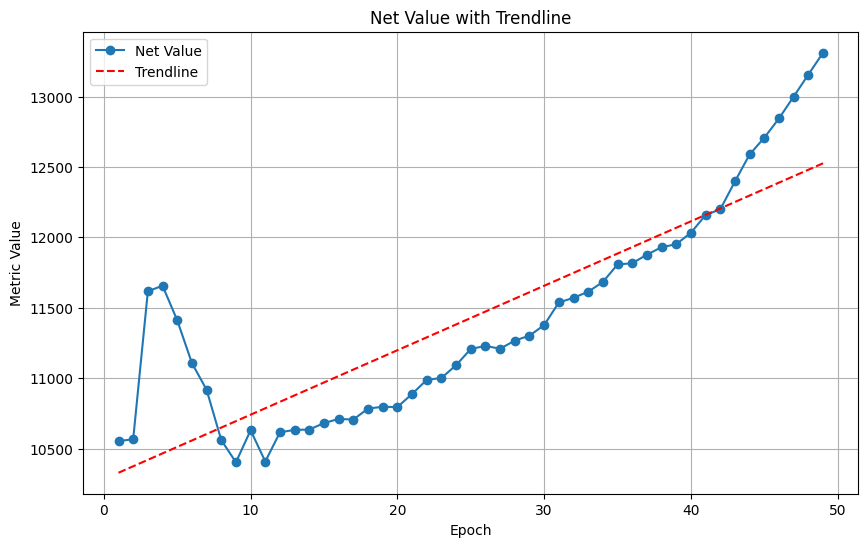

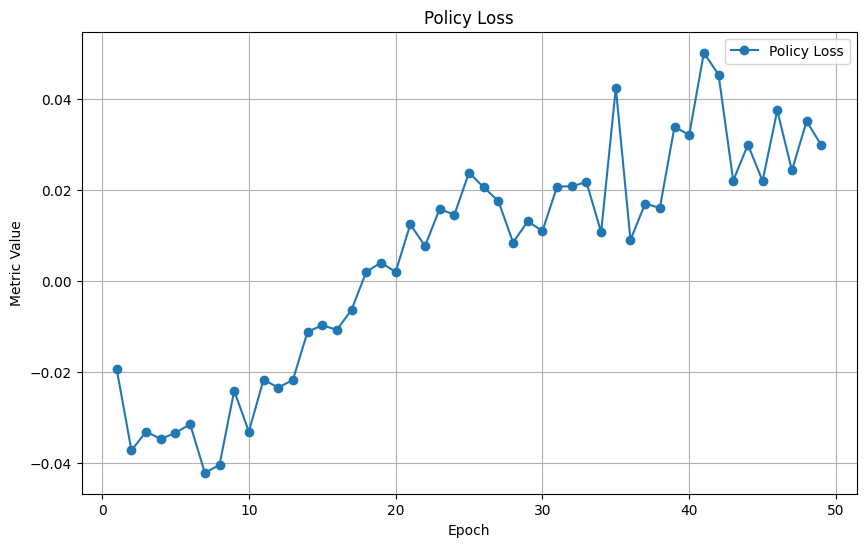

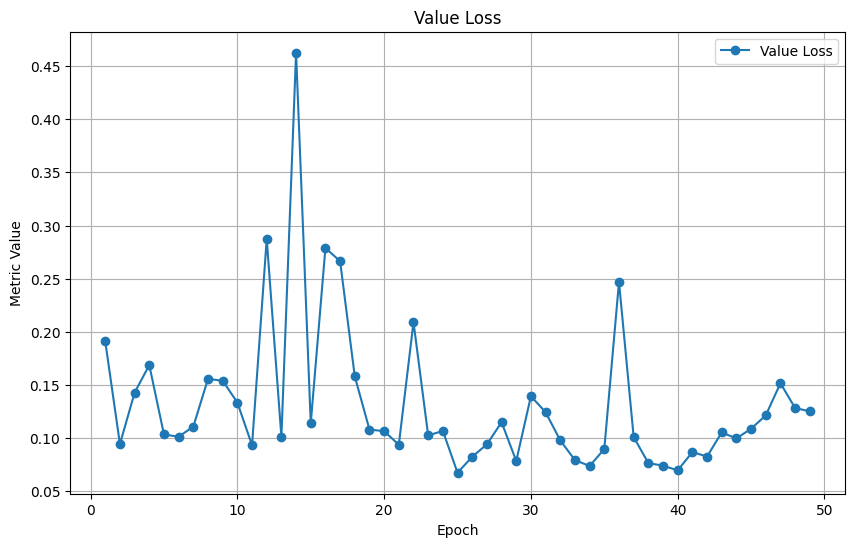

2024-11-25 19:29:43,493	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 19:29:43,518	INFO trainable.py:161 -- Trainable.setup took 14.897 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 19:29:43,520	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 4
Training iteration 1, Hyperparameter tuned = 4
Epoch 1: Policy Loss=-0.010350471120327711, Value Loss=0.14383468055166304
Training iteration 2, Hyperparameter tuned = 4
Epoch 2: Policy Loss=-0.02745838090777397, Value Loss=0.09830220284406095
Training iteration 3, Hyperparameter tuned = 4
Epoch 3: Policy Loss=-0.022447032462805508, Value Loss=0.0753657932113856
Training iteration 4, Hyperparameter tuned = 4
Epoch 4: Policy Loss=-0.03353188507258892, Value Loss=0.1230790433101356
Training iteration 5, Hyperparameter tuned = 4
Epoch 5: Policy Loss=-0.029239201713353397, Value Loss=0.08060122214257717
Training iteration 6, Hyperparameter tuned = 4
Epoch 6: Policy Loss=-0.0326445984095335, Value Loss=0.11877484736498445
Training iteration 7, Hyperparameter tuned = 4
Epoch 7: Policy Loss=-0.037059200294315815, Value Loss=0.09034803274087608
Training iteration 8, Hyperparameter tuned = 4
Epoch 8: Policy Loss=-0.01894867841154337, Value Loss=0.07

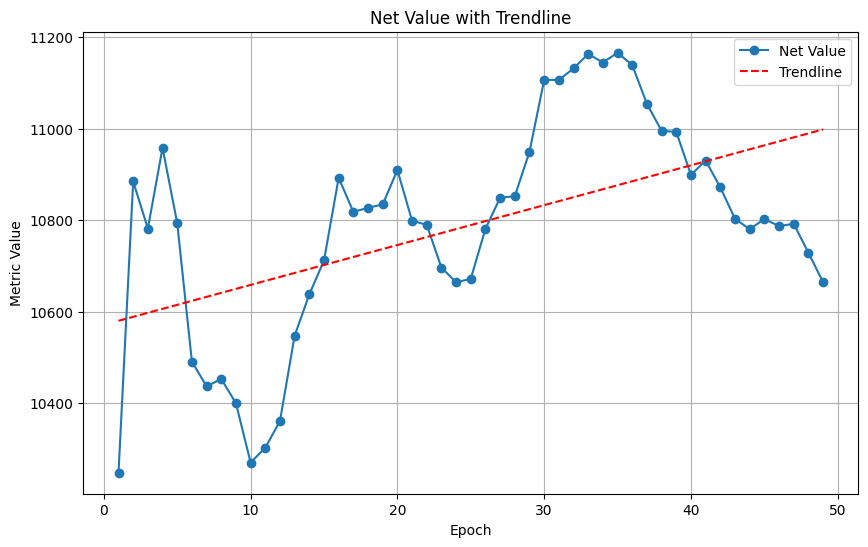

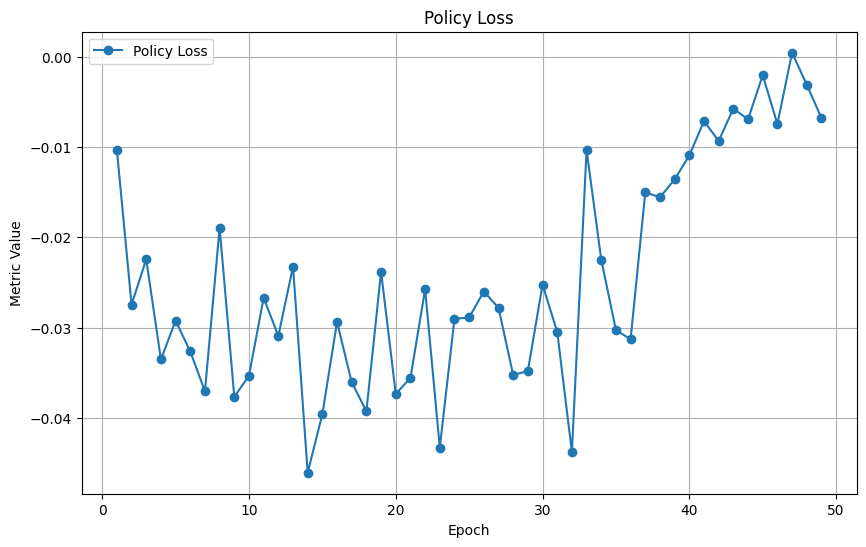

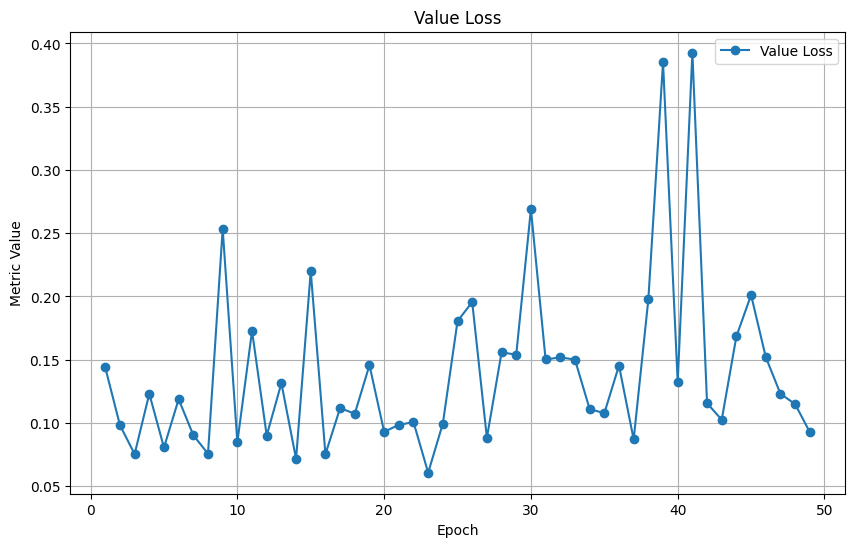

2024-11-25 19:44:26,579	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 19:44:26,603	INFO trainable.py:161 -- Trainable.setup took 13.928 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 19:44:26,604	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 8
Training iteration 1, Hyperparameter tuned = 8
Epoch 1: Policy Loss=-0.03797226129099727, Value Loss=0.1006382412649691
Training iteration 2, Hyperparameter tuned = 8
Epoch 2: Policy Loss=-0.05139164683409035, Value Loss=0.06322097812779248
Training iteration 3, Hyperparameter tuned = 8
Epoch 3: Policy Loss=-0.035115030854940416, Value Loss=0.06416035103611648
Training iteration 4, Hyperparameter tuned = 8
Epoch 4: Policy Loss=-0.0381276497989893, Value Loss=0.06739327549468727
Training iteration 5, Hyperparameter tuned = 8
Epoch 5: Policy Loss=-0.031409606160596015, Value Loss=0.06520546582527459
Training iteration 6, Hyperparameter tuned = 8
Epoch 6: Policy Loss=-0.03152239099144936, Value Loss=0.06842781281098724
Training iteration 7, Hyperparameter tuned = 8
Epoch 7: Policy Loss=-0.038236449956893924, Value Loss=0.05929443051572889
Training iteration 8, Hyperparameter tuned = 8
Epoch 8: Policy Loss=-0.030920956060290338, Value Loss=0.0

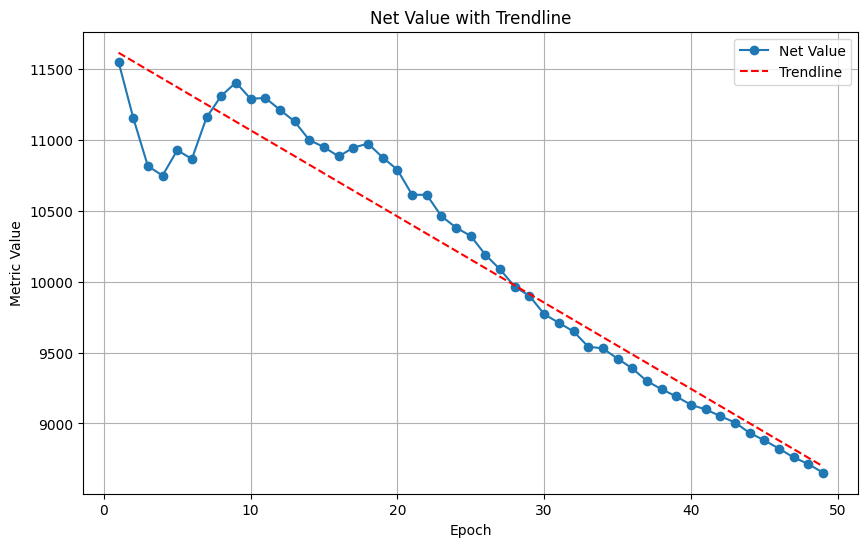

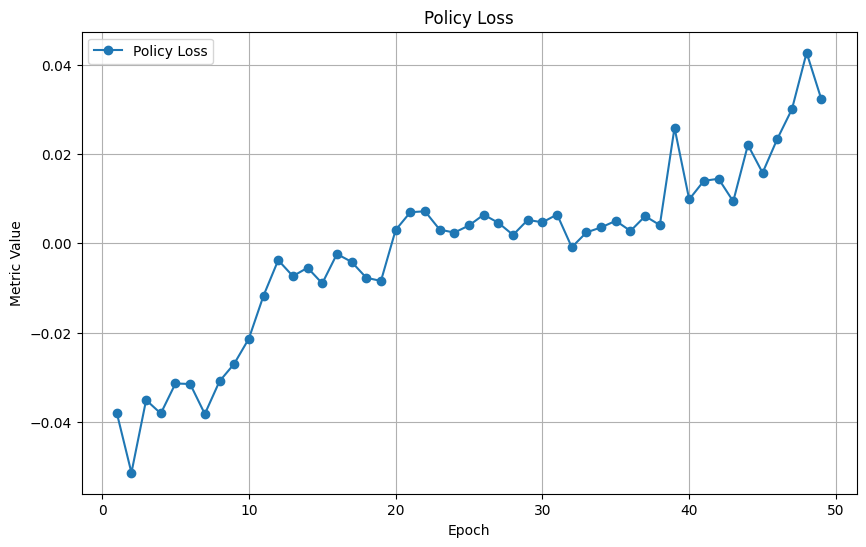

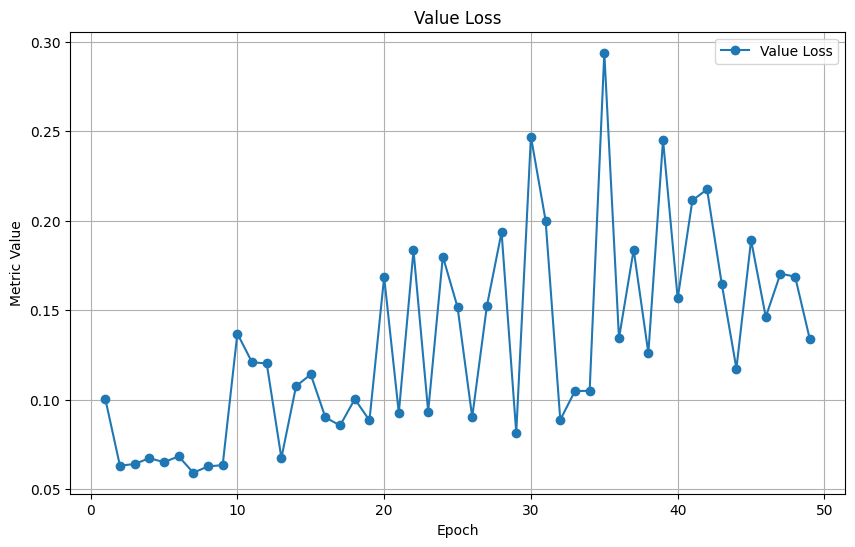

2024-11-25 20:01:39,217	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 20:01:39,242	INFO trainable.py:161 -- Trainable.setup took 14.592 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 20:01:39,244	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 19
Training iteration 1, Hyperparameter tuned = 19
Epoch 1: Policy Loss=-0.026185801699757576, Value Loss=0.11509888540022076
Training iteration 2, Hyperparameter tuned = 19
Epoch 2: Policy Loss=-0.0410409670881927, Value Loss=0.10674272081814706
Training iteration 3, Hyperparameter tuned = 19
Epoch 3: Policy Loss=-0.03778140567243099, Value Loss=0.12581026813946664
Training iteration 4, Hyperparameter tuned = 19
Epoch 4: Policy Loss=-0.04682102601975203, Value Loss=0.07894136011134834
Training iteration 5, Hyperparameter tuned = 19
Epoch 5: Policy Loss=-0.039495622143149375, Value Loss=0.08662742003332824
Training iteration 6, Hyperparameter tuned = 19
Epoch 6: Policy Loss=-0.03238891564309597, Value Loss=0.3063333702646196
Training iteration 7, Hyperparameter tuned = 19
Epoch 7: Policy Loss=-0.07077213279902934, Value Loss=0.0713488010596484
Training iteration 8, Hyperparameter tuned = 19
Epoch 8: Policy Loss=-0.026372598074376582, Value L

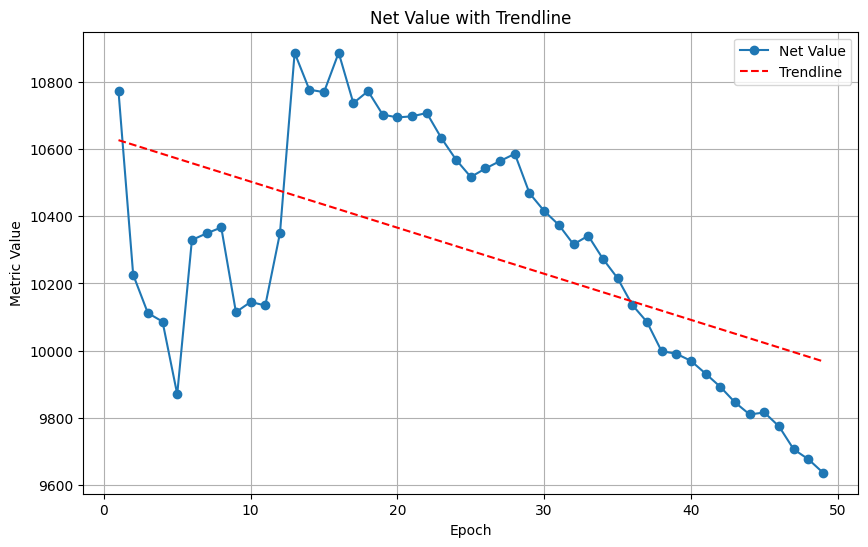

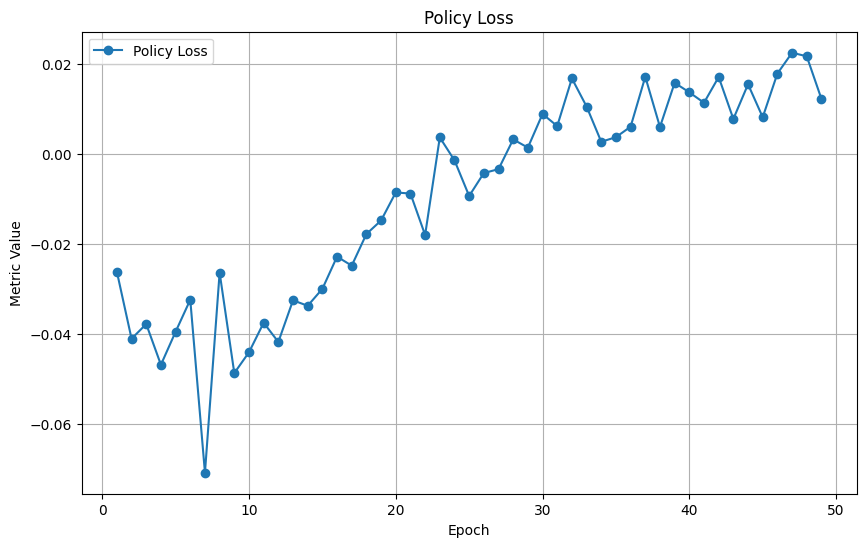

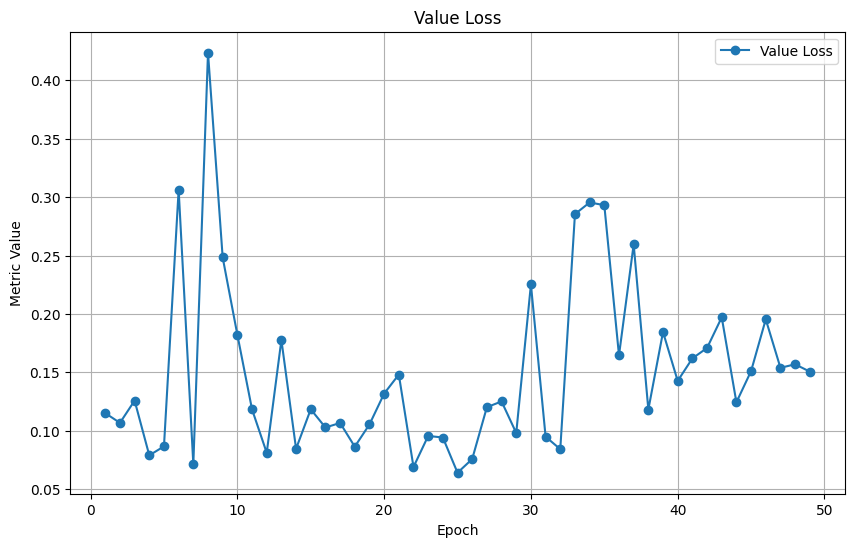

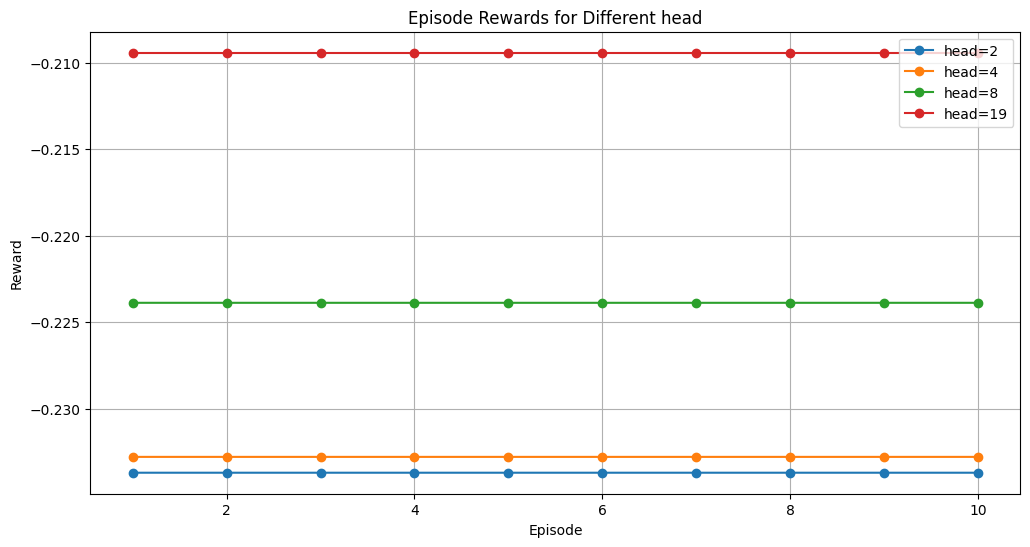

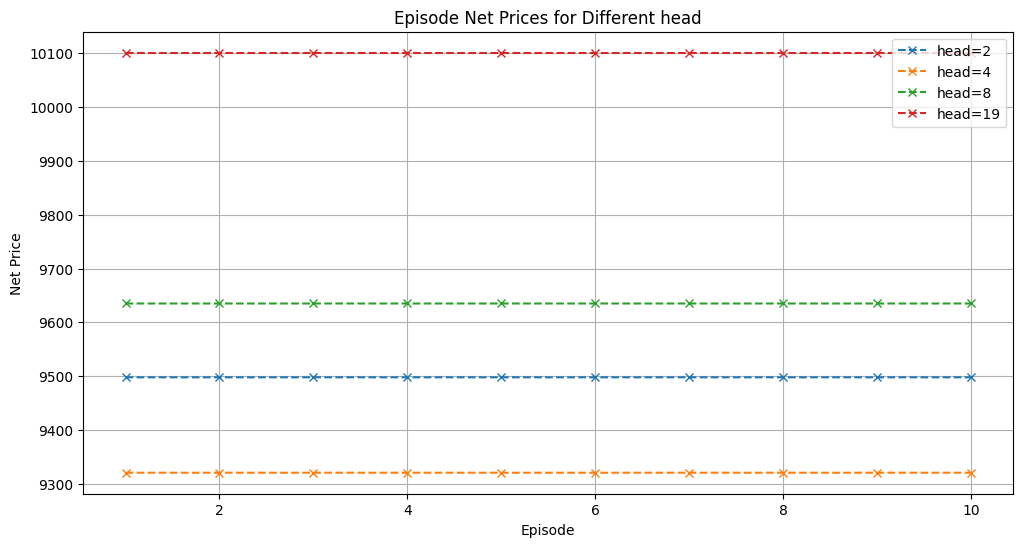

In [ ]:

ray.init(ignore_reinit_error=True)

def env_creator(env_config):
    return PortfolioOptimizationEnv(env_config)

register_env('my_portfolio_env', env_creator)

head_size_list = [2,4,8,19]

eval_rewards = {}
eval_net_prices = {}

def evaluate(trainer, env, num_episodes=10):
    all_rewards = []
    net_prices = []

    for episode in range(num_episodes):
        episode_reward = 0
        done = False
        truncated = False
        obs = env.reset()

        while not done and not truncated:
            if isinstance(obs, tuple):
                obs_input = obs[0]
            elif isinstance(obs, dict):
                obs_input = obs["obs"]
            else:
                obs_input = obs

            action = trainer.compute_single_action(obs_input, explore=False)
            obs, reward, done, truncated, info = env.step(action)
            episode_reward += reward

        all_rewards.append(episode_reward)
        net_price = env.net_price[-1]
        net_prices.append(net_price)

    return all_rewards, net_prices

for head in head_size_list:
    config['model']['custom_model_config']['n_head'] = head

    algo = (
        PPOConfig()
        .environment('my_portfolio_env', env_config=config['env_config'])
        .framework('torch')
        .resources(num_gpus=1)
        .env_runners(num_env_runners=config['num_workers'])
        .training(
            model=config['model'],
            lr=config['lr'],
            train_batch_size=config['train_batch_size'],
            num_epochs=config['num_epochs']
        )
        .api_stack(
            enable_rl_module_and_learner=False,
            enable_env_runner_and_connector_v2=False
        )
        .rollouts(sample_timeout_s=300)
        .callbacks(CustomMetricsCallback)
        .build()
    )

    num_epochs = 50
    epoch_net_values = []
    epoch_policy_loss = []
    epoch_value_loss = []

    for i in range(num_epochs):
        print(f"Training iteration {i}, Hyperparameter tuned = {head}")
        result = algo.train()
        if i != 0:
            policy_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["policy_loss"]
            value_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["vf_loss"]
            net_value = result["env_runners"]["custom_metrics"]["final_net_price_mean"]
            epoch_policy_loss.append(policy_loss)
            epoch_value_loss.append(value_loss)
            epoch_net_values.append(net_value)
            print(f"Epoch {i}: Policy Loss={policy_loss}, Value Loss={value_loss}")
            torch.cuda.empty_cache()

    epochs = range(1, len(epoch_policy_loss) + 1)
    epochs = np.array(epochs)
    epoch_net_values = np.array(epoch_net_values)

    coefficients = np.polyfit(epochs, epoch_net_values, deg=1)
    trendline = np.polyval(coefficients, epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_net_values, marker='o', label='Net Value')
    plt.plot(epochs, trendline, color='red', linestyle='--', label='Trendline')

    plt.title(f'Net Value with Trendline')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()



    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_policy_loss, marker='o', label='Policy Loss')
    plt.title(f'Policy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_value_loss, marker='o', label='Value Loss')
    plt.title(f'Value Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()


    evaluation_env = PortfolioOptimizationEnv(config['val_env_config'])
    all_rewards, net_prices = evaluate(algo, evaluation_env, num_episodes=10)
    evaluation_env.close()

    eval_rewards[head] = all_rewards
    eval_net_prices[head] = net_prices

plt.figure(figsize=(12, 6))
for head, rewards in eval_rewards.items():
    episodes = range(1, len(rewards) + 1)
    plt.plot(episodes, rewards, marker='o', linestyle='-', label=f'head={head}')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards for Different head')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for head, net_prices in eval_net_prices.items():
    episodes = range(1, len(net_prices) + 1)
    plt.plot(episodes, net_prices, marker='x', linestyle='--', label=f'head={head}')
plt.xlabel('Episode')
plt.ylabel('Net Price')
plt.title('Episode Net Prices for Different head')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
head_size_list2 = [38,76]
for head in head_size_list2:
    config['model']['custom_model_config']['n_head'] = head

    algo = (
        PPOConfig()
        .environment('my_portfolio_env', env_config=config['env_config'])
        .framework('torch')
        .resources(num_gpus=1)
        .env_runners(num_env_runners=config['num_workers'])
        .training(
            model=config['model'],
            lr=config['lr'],
            train_batch_size=config['train_batch_size'],
            num_epochs=config['num_epochs']
        )
        .api_stack(
            enable_rl_module_and_learner=False,
            enable_env_runner_and_connector_v2=False
        )
        .rollouts(sample_timeout_s=300)
        .callbacks(CustomMetricsCallback)
        .build()
    )

    num_epochs = 50
    epoch_net_values = []
    epoch_policy_loss = []
    epoch_value_loss = []

    for i in range(num_epochs):
        print(f"Training iteration {i}, Hyperparameter tuned = {head}")
        result = algo.train()
        if i != 0:
            policy_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["policy_loss"]
            value_loss = result["info"]["learner"]["default_policy"]["learner_stats"]["vf_loss"]
            net_value = result["env_runners"]["custom_metrics"]["final_net_price_mean"]
            epoch_policy_loss.append(policy_loss)
            epoch_value_loss.append(value_loss)
            epoch_net_values.append(net_value)
            print(f"Epoch {i}: Policy Loss={policy_loss}, Value Loss={value_loss}")
            torch.cuda.empty_cache()

    epochs = range(1, len(epoch_policy_loss) + 1)
    epochs = np.array(epochs)
    epoch_net_values = np.array(epoch_net_values)

    coefficients = np.polyfit(epochs, epoch_net_values, deg=1)
    trendline = np.polyval(coefficients, epochs)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_net_values, marker='o', label='Net Value')
    plt.plot(epochs, trendline, color='red', linestyle='--', label='Trendline')

    plt.title(f'Net Value with Trendline')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()



    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_policy_loss, marker='o', label='Policy Loss')
    plt.title(f'Policy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, epoch_value_loss, marker='o', label='Value Loss')
    plt.title(f'Value Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()


    evaluation_env = PortfolioOptimizationEnv(config['val_env_config'])
    all_rewards, net_prices = evaluate(algo, evaluation_env, num_episodes=10)
    evaluation_env.close()

    eval_rewards[head] = all_rewards
    eval_net_prices[head] = net_prices

plt.figure(figsize=(12, 6))
for head, rewards in eval_rewards.items():
    episodes = range(1, len(rewards) + 1)
    plt.plot(episodes, rewards, marker='o', linestyle='-', label=f'head={head}')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Episode Rewards for Different head')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
for head, net_prices in eval_net_prices.items():
    episodes = range(1, len(net_prices) + 1)
    plt.plot(episodes, net_prices, marker='x', linestyle='--', label=f'head={head}')
plt.xlabel('Episode')
plt.ylabel('Net Price')
plt.title('Episode Net Prices for Different head')
plt.legend()
plt.grid(True)
plt.show()

2024-11-25 20:27:35,737	WARNING catalog.py:547 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2024-11-25 20:27:35,767	INFO trainable.py:161 -- Trainable.setup took 14.766 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2024-11-25 20:27:35,769	WARNING util.py:61 -- Install gputil for GPU system monitoring.


Training iteration 0, Hyperparameter tuned = 38
Training iteration 1, Hyperparameter tuned = 38
Epoch 1: Policy Loss=-0.038610765412449836, Value Loss=0.1457686305232346
Training iteration 2, Hyperparameter tuned = 38
Epoch 2: Policy Loss=-0.038808266520500186, Value Loss=0.09274163013324141
Training iteration 3, Hyperparameter tuned = 38
Epoch 3: Policy Loss=-0.03131419073790312, Value Loss=0.19053000174928456
Training iteration 4, Hyperparameter tuned = 38
Epoch 4: Policy Loss=-0.05899078954011202, Value Loss=0.10829413268715143
Training iteration 5, Hyperparameter tuned = 38
Epoch 5: Policy Loss=-0.055691246408969164, Value Loss=0.07818480206653476
Training iteration 6, Hyperparameter tuned = 38
Epoch 6: Policy Loss=-0.027906165327876806, Value Loss=0.12187565165106207
Training iteration 7, Hyperparameter tuned = 38
Epoch 7: Policy Loss=-0.027971169371157886, Value Loss=0.21192998284474016
Training iteration 8, Hyperparameter tuned = 38
Epoch 8: Policy Loss=-0.030235755890607834, Va

ValueError: Expected parameter loc (Tensor of shape (128, 5)) of distribution Normal(loc: torch.Size([128, 5]), scale: torch.Size([128, 5])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], device='cuda:0', grad_fn=<SplitBackward0>)
 tracebackTraceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/ray/rllib/policy/torch_policy_v2.py", line 1151, in _worker
    self.loss(model, self.dist_class, sample_batch)
  File "/usr/local/lib/python3.10/dist-packages/ray/rllib/algorithms/ppo/ppo_torch_policy.py", line 85, in loss
    curr_action_dist = dist_class(logits, model)
  File "/usr/local/lib/python3.10/dist-packages/ray/rllib/models/torch/torch_action_dist.py", line 250, in __init__
    self.dist = torch.distributions.normal.Normal(mean, torch.exp(log_std))
  File "/usr/local/lib/python3.10/dist-packages/torch/distributions/normal.py", line 59, in __init__
    super().__init__(batch_shape, validate_args=validate_args)
  File "/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py", line 71, in __init__
    raise ValueError(
ValueError: Expected parameter loc (Tensor of shape (128, 5)) of distribution Normal(loc: torch.Size([128, 5]), scale: torch.Size([128, 5])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], device='cuda:0', grad_fn=<SplitBackward0>)

In tower 0 on device cuda:0

Save the model

In [ ]:
checkpoint_path = algo.save()
print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/tmp/tmpbw9i15uq), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'custom_metrics': {}, 'learner_stats': {'cur_kl_coeff': 86287.97665479784, 'cur_lr': 0.004999999999999999, 'total_loss': 5477.91236038208, 'policy_loss': 0.012185524022206663, 'vf_loss': 0.15062507349066437, 'vf_explained_var': 0.045244929194450376, 'kl': 0.06348218777216971, 'entropy': 10.701734454631806, 'entropy_coeff': 0.0}, 'model': {}, 'num_grad_updates_lifetime': 19800.5, 'diff_num_grad_updates_vs_sampler_policy': 199.5}}, 'num_env_steps_sampled': 25600, 'num_env_steps_trained': 25600, 'num_agent_steps_sampled': 25600, 'num_agent_steps_trained': 25600}, 'env_runners': {'episode_reward_max': 1.7161769745286892, 'episode_reward_min': -3.792456413237909, 'episode_reward_mean': -1.056604047107553, 'episode_len_mean': 502.0, 'episode_media': {}, 'episodes_timesteps_total': 25100, 'policy_reward_